<a href="https://colab.research.google.com/github/Mdipietro1990/masters-program/blob/CNN_models_HW/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Loading in the data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import's used for this notebook


In [2]:
!pip install mxnet
!pip install gluoncv 

import IPython.display
import tensorflow as tf

In [0]:
import gluoncv

from gluoncv import model_zoo, data, utils

In [4]:
import IPython.display
from keras.models import load_model, Model
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import image as kp_image
from keras import models 
from keras import losses
from keras import layers

import scipy.io
import scipy.misc
import numpy as np

from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
import os
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
import pandas as pd
import PIL
import struct
import cv2

from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from PIL import Image


from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K




Using TensorFlow backend.


# YOLOv3 model 


## Using weights for this model from a pre trained yolo model

In [0]:
class ReadWeight:
    """
    Funtion to read in the pre trained weights for the model
    """
    def __init__(self, weight_info):
        with open(weight_info, 'rb') as wi:
            major, = struct.unpack('i', wi.read(4))
            minor, = struct.unpack('i', wi.read(4))
            revision, = struct.unpack('i', wi.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                wi.read(8)
            else:
                wi.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = wi.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_data(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weight_file(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    b = self.read_data(size) # bias value
                    g = self.read_data(size) # scale value
                    m = self.read_data(size) # mean value
                    var = self.read_data(size) # variance value         

                    weights = norm_layer.set_weights([g, b, m, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_data(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_data(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_data(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution layer #" + str(i))     
    
    def reset(self):
        self.offset = 0

## Function to build the convolutional layers

In [0]:

def _conv_block(inp, convs, skip=True):
    x = inp
    cnt = 0
    
    for conv in convs:
        if cnt == (len(convs) - 2) and skip:
            skip_con = x
        cnt += 1
        # padding for the darknet as darknet prefers left and top
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) 
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', 
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_con, x]) if skip else x

## Building the individual yolo layers

In [0]:
def make_yolo3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer == layer_index value for each layer. this set is 0 -> 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer == layer_index value for each layer. this set is 5 -> 7
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer == layer_index value for each layer. this set is 9 -> 10
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer == layer_index value for each layer. this set is 12 -> 14
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer == layer_index value for each layer. this set is 16 -> 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer == layer_index value for each layer. this set is 37 -> 39
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer == layer_index value for each layer. this set is 41 -> 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer == layer_index value for each layer. this set is 62 -> 64
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer == layer_index value for each layer. this set is 66 -> 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer == layer_index value for each layer. this set is 75 -> 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer == layer_index value for each layer. this set is 80 -> 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer == layer_index value for each layer. this set is 83 -> 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer == layer_index value for each layer. this set is 87 -> 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer == layer_index value for each layer. this set is 92 -> 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer == layer_index value for each layer. this set is 95 -> 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer == layer_index value for each layer. this set is 99 -> 105
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

## Setting up all the variables that can be used in the yolo model
Images that the model can detect


In [9]:
tf.compat.v1.placeholder
tf.compat.v1.get_default_graph

<function tensorflow.python.framework.ops.get_default_graph>

In [10]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# make the yolov3 model to predict 80 classes on COCO

yolo3 = make_yolo3_model()

# load the weights trained on COCO into the model
read_weight = ReadWeight('/content/drive/My Drive/Emerging tech Homework 4/yolov3.weights')
read_weight.load_weight_file(yolo3)













loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution layer #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution layer #8
loading weights of convolution #9
loading weights of convolution #10
no convolution layer #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution layer #15
loading weights of convolution #16
loading weights of convolution #17
no convolution layer #18
loading weights of convolution #19
loading weights of convolution #20
no convolution layer #21
loading weights of convolution #22
loading weights of convolution #23
no convolution layer #24
loading weights of convolution #25
loading weights of convolution #26
no convolution layer #27
loading weights of convolution #28
loading weights of convolution #29
no convolution layer #30
loa

In [0]:
def save_model():
  yolo3.save('/content/drive/My Drive/Emerging tech Homework 4/Model/yolo3.h5')

In [0]:
def load_yolo_model():
  yolo3 = load_model('/content/drive/My Drive/Emerging tech Homework 4/Model/yolo3.h5')
  return yolo3

In [0]:
save_model()

In [14]:
yolo3 = load_yolo_model()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def load_image_size(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float16')
    image /= 255.0
    image = expand_dims(image, 0)
    return image, width, height

## Building the boundery box used on the image

In [0]:
class BoundaryBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_image_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_image_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_image_label()]
            
        return self.score

In [0]:
def sigmoid_func(x):
    return 1. / (1. + np.exp(-x))

def interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 
def bbox_iou(box1, box2):
    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [0]:
def decode_netout(netout, anchors, obj_thresh,  net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []
    netout[..., :2]  = sigmoid_func(netout[..., :2])
    netout[..., 4:]  = sigmoid_func(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            objectness = netout[int(row)][int(col)][b][4]
            
            if(objectness.all() <= obj_thresh): continue
            
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w 
            y = (row + y) / grid_h 
            w = anchors[2 * b + 0] * np.exp(w) / net_w # image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # image height  

            classes = netout[int(row)][col][b][5:]
            
            box = BoundaryBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)

            boxes.append(box)

    return boxes

In [0]:
def yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [0]:
def draw_boxes_on_image(filename, v_boxes, v_labels, v_scores):
    data = plt.imread(filename)
    plt.imshow(data)
    ax = plt.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
    plt.show()

In [0]:
def get_image_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)

    return v_boxes, v_labels, v_scores

## Running the yolo model on data found on google image
I am using a picture of a golder retriver with a red ball.

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
dog 99.88230466842651
sports ball 84.12752151489258
apple 70.39765119552612


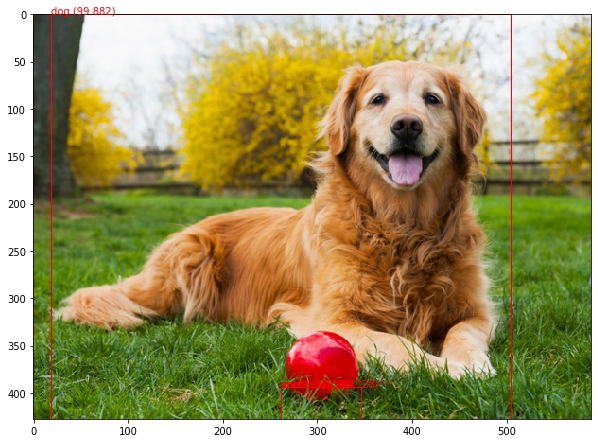

In [22]:
input_w, input_h = 416, 416
photo_filename = '/content/drive/My Drive/Emerging tech Homework 4/dog.jpg'

image, image_w, image_h = load_image_size(photo_filename, (net_w, net_w))
yolos = yolo3.predict(image)
print([a.shape for a in yolos])

anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
class_threshold = 0.6
boxes = list()

for i in range(len(yolos)):
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh,  net_h, net_w)

yolo_boxes(boxes, image_h, image_w, net_h, net_w)
do_nms(boxes, nms_thresh)
v_boxes, v_labels, v_scores = get_image_boxes(boxes, labels, class_threshold)

for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

draw_boxes_on_image(photo_filename, v_boxes, v_labels, v_scores)

#Deeplab visualization

In [0]:
class DeepLabModel(object):
#deeeplab model will add the color to the image and label what makes up the image

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    self.graph = tf.Graph()

    graph_def = None
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  #  A Colormap for visualizing segmentation results
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv', 'ball'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [58]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Image visualization

running deeplab on image https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2016/05/14093237/samoyed-mother-dog-with-puppy-outdoors.jpg...


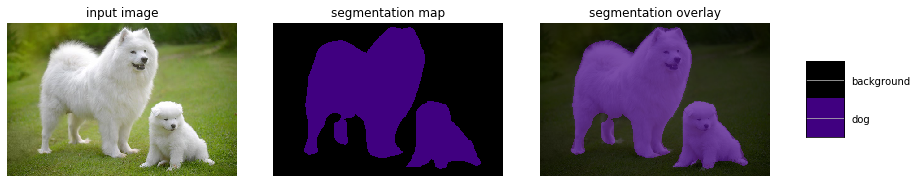

In [61]:
SAMPLE_IMAGE = 'image2'  
# IMAGE_URL = #'https://www.vcphd.org/files/2314/9426/3372/animal-control.jpg' 
IMAGE_URL = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2016/05/14093237/samoyed-mother-dog-with-puppy-outdoors.jpg'
# 'https://www.petmd.com/sites/default/files/senior-golden-retriever-with-ball-picture-id488657289.jpg'
_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

# FaceNet model 


In [62]:
cascade_path = '/content/drive/My Drive/Emerging tech Homework 4/Model/haarcascade_frontalface_alt2.xml'
image_dir_basepath = '/content/drive/My Drive/Emerging tech Homework 4/images/'
names = ['LarryPage', 'MarkZuckerberg', 'BillGates']
image_size = 160

model_path = '/content/drive/My Drive/Emerging tech Homework 4/Model/facenet_keras.h5'
model = load_model(model_path)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [0]:

def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [0]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs


In [0]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        
    embs = np.concatenate(embs)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [0]:
def infer(le, clf, filepaths):
    embs = calc_embs(filepaths)
    pred = le.inverse_transform(clf.predict(embs))
    return pred

In [0]:
le, clf = train(image_dir_basepath, names)

In [33]:
le
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [35]:
test_filepaths

['/content/drive/My Drive/Emerging tech Homework 4/images/Test/test1.jpg',
 '/content/drive/My Drive/Emerging tech Homework 4/images/Test/test0.jpg',
 '/content/drive/My Drive/Emerging tech Homework 4/images/Test/test2.jpg']

In [0]:
pred = infer(le, clf, test_filepaths)

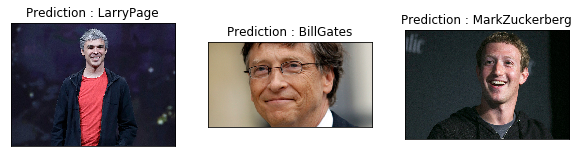

In [37]:

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    axes[i].set_title('Prediction : '+str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

# Faster RCNN

In [38]:
RCNN_model = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True)

Model file is not found. Downloading.


121888KB [00:01, 78462.08KB/s]                            


In [39]:
image_name = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                            'gluoncv/detection/biking.jpg?raw=true',
                             path='/content/biking.jpg')
x, image = data.transforms.presets.rcnn.load_test(image_name)

100%|██████████| 244/244 [00:00<00:00, 8424.10KB/s]


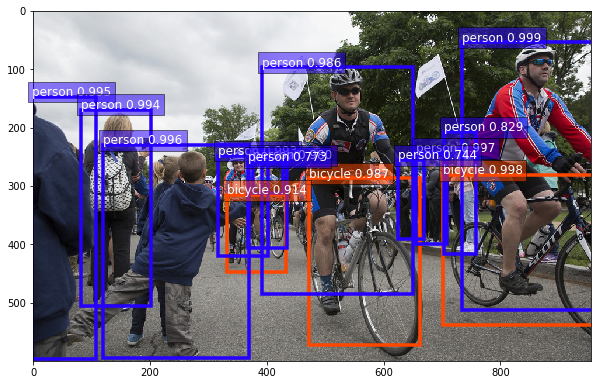

In [40]:
box_ids, scores, bboxes = RCNN_model(x)
ax = utils.viz.plot_bbox(image, bboxes[0], scores[0], box_ids[0], class_names=RCNN_model.classes)

plt.show()

# Masked RCNN


In [41]:
masked_model = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True)

Model file is not found. Downloading.


100%|██████████| 131497/131497 [00:01<00:00, 77441.35KB/s]


In [0]:
image_name = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/detection/biking.jpg?raw=true',
                          path='biking.jpg')
x, image = data.transforms.presets.rcnn.load_test(image_name)

In [0]:
ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in masked_model(x)]

width, height = image.shape[1], image.shape[0]
masks, _ = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
image = utils.viz.plot_mask(image, masks)

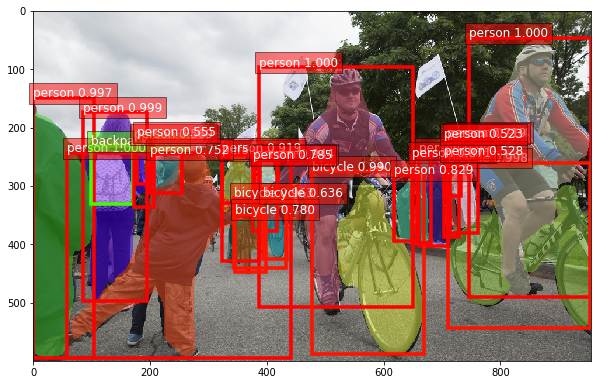

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax = utils.viz.plot_bbox(image, bboxes, scores, ids,
                         class_names=masked_model.classes, ax=ax)
plt.show()

# LSTM stock prediction

In [0]:
data = pd.read_csv('/content/drive/My Drive/Emerging tech Homework 4/data/all_stocks_5yr.csv')
cl = data[data['Name']=='MMM'].close

In [46]:
data.head()

date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

In [47]:
data.Name.unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

In [48]:
scl = MinMaxScaler()
#Scale the data
cl = cl.values.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
cl

array([[0.00580061],
       [0.00554564],
       [0.01090005],
       ...,
       [0.82668281],
       [0.84064253],
       [0.83783784]])

In [49]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
X,y = processData(cl,7)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1000
251
1000
251


In [50]:
model = Sequential()
model.add(LSTM(256,input_shape=(7,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1000 samples, validate on 251 samples
Epoch 1/300
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 2/300
1000/1000 [==============================] - 1s 532us/step - loss: 0.0075 - val_loss: 0.0027
Epoch 3/300
1000/1000 [==============================] - 1s 518us/step - loss: 0.0018 - val_loss: 7.3706e-04
Epoch 4/300
1000/1000 [==============================] - 1s 517us/step - loss: 6.7284e-04 - val_loss: 0.0015
Epoch 5/300
1000/1000 [==============================] - 1s 527us/step - loss: 5.6961e-04 - val_loss: 5.9174e-04
Epoch 6/300
1000/1000 [==============================] - 1s 525us/step - loss: 5.1480e-04 - val_loss: 7.7026e-04
Epoch 7/300
1000/1000 [==============================] - 1s 520us/step - loss: 5.5412e-04 - val_loss: 9.7012e-04
Epoch 8/300
1000/1000 [==============================] - 1s 503us/step - loss: 7.5882e-04 -

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

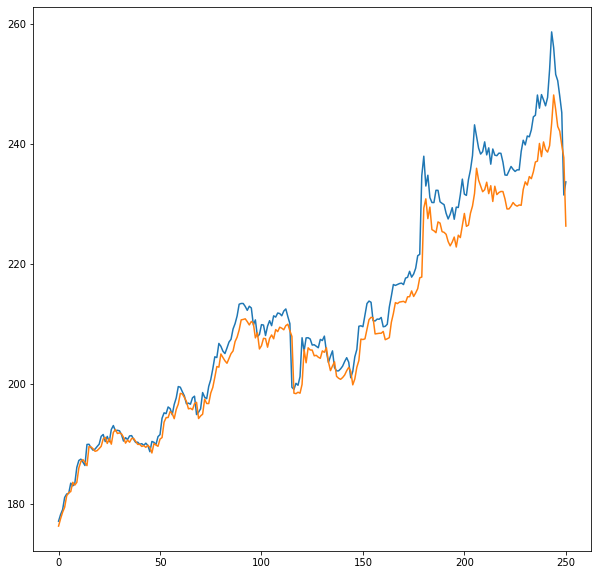

In [52]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [53]:
act = []
pred = []

i=249
Xt = model.predict(X_test[i].reshape(1,7,1))
print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
pred.append(scl.inverse_transform(Xt))
act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))

predicted:[[237.67944]], actual:[[231.44]]


In [0]:
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})

In [55]:
result_df

pred     act
0  237.679443  231.44

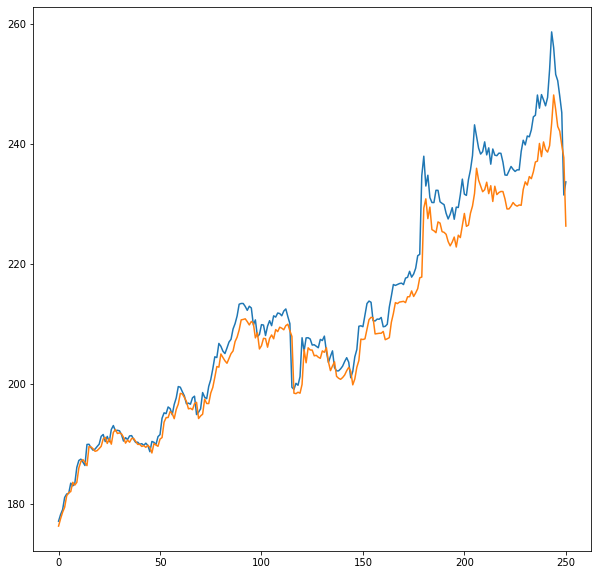

In [56]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [57]:
X_test[150]

array([[0.64896736],
       [0.63252167],
       [0.63934217],
       [0.65470423],
       [0.66254462],
       [0.68721316],
       [0.6877231 ]])

# Style Transfer 

In [5]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
!wget https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg -P '/content/drive/My Drive/Emerging tech Homework 4/images/'
!wget https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg -P '/content/drive/My Drive/Emerging tech Homework 4/images/'
!wget https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg -P '/content/drive/My Drive/Emerging tech Homework 4/images/'
!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P '/content/drive/My Drive/Emerging tech Homework 4/images/'
!wget https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg -P '/content/drive/My Drive/Emerging tech Homework 4/images/' 
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P '/content/drive/My Drive/Emerging tech Homework 4/images/'
!wget https://upload.wikimedia.org/wikipedia/commons/6/62/Starsinthesky.jpg -P '/content/drive/My Drive/Emerging tech Homework 4/images/' 

In [0]:
content_path = '/content/drive/My Drive/Emerging tech Homework 4/images/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/content/drive/My Drive/Emerging tech Homework 4/images/Starsinthesky.jpg'

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

In [16]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():

  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def gram_matrix(input_tensor):

  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)


In [0]:
def get_style_loss(base_style, gram_target):

  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [0]:
def get_feature_representations(model, content_path, style_path):


  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights

  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 

  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  

  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  

  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)


  iter_count = 1
  

  best_loss, best_img = float('inf'), None
  

  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:

      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      

      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

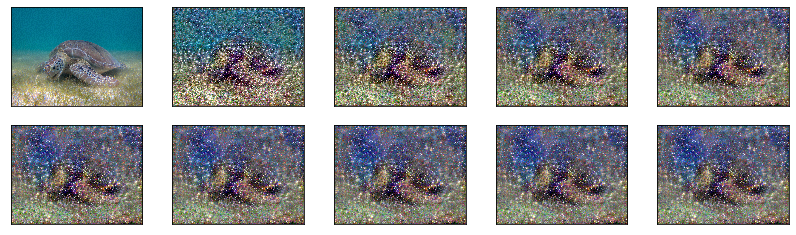

In [28]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

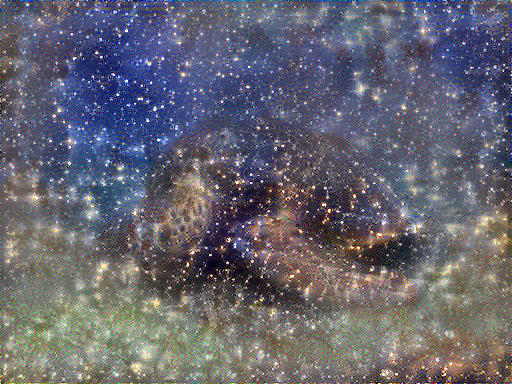

In [29]:
Image.fromarray(best)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

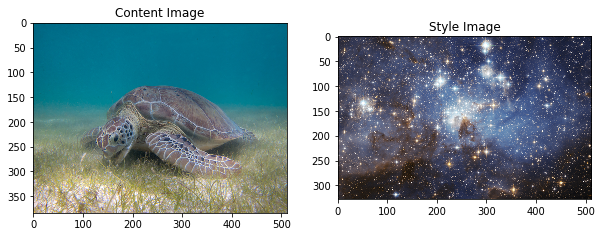

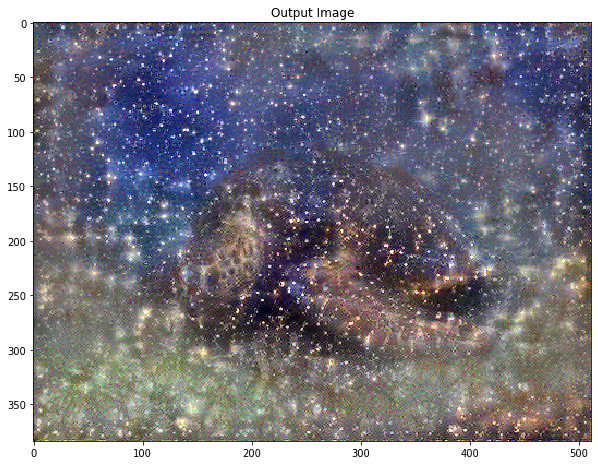

In [31]:
show_results(best, content_path, style_path)

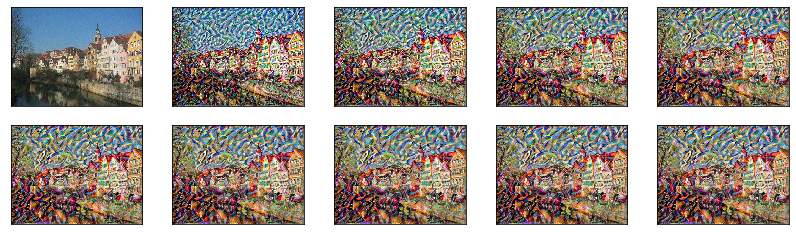

In [32]:
best_starry_night, best_loss = run_style_transfer('/content/drive/My Drive/Emerging tech Homework 4/images/Tuebingen_Neckarfront.jpg',
                                                  '/content/drive/My Drive/Emerging tech Homework 4/images/Vassily_Kandinsky,_1913_-_Composition_7.jpg')